In [ ]:
# %%

import base64
import functools
import html
import io
import os
import warnings

import jax
import jax.lib
import jax.numpy as jnp
import kagglehub
import ml_collections
import numpy as np
import sentencepiece
import tensorflow as tf
from IPython.core.display import HTML, display
from PIL import Image

# Import big vision utilities
import big_vision.datasets.jsonl
import big_vision.sharding
import big_vision.utils

# Import model definition from big_vision
from big_vision.models.proj.paligemma import paligemma
from big_vision.trainers.proj.paligemma import predict_fns

SEQLEN = 128


def init_devices():
    # Don't let TF use the GPU or TPUs
    tf.config.set_visible_devices([], "GPU")
    tf.config.set_visible_devices([], "TPU")

    backend = jax.lib.xla_bridge.get_backend()
    print(f"JAX version:  {jax.__version__}")
    print(f"JAX platform: {backend.platform}")
    print(f"JAX devices:  {jax.device_count()}")


def load_pretrained_model():
    MODEL_PATH = "./pt_224_128.params.f16.npz"
    if not os.path.exists(MODEL_PATH):
        print(
            "Downloading the checkpoint from Kaggle, this could take a few minutes...."
        )
        # Download only the float16 model.
        MODEL_PATH = kagglehub.model_download(
            "google/paligemma/jax/paligemma-3b-pt-224", "paligemma-3b-pt-224.f16.npz"
        )
        print(f"Model path: {MODEL_PATH}")

    TOKENIZER_PATH = "./paligemma_tokenizer.model"
    if not os.path.exists(TOKENIZER_PATH):
        print("Downloading the model tokenizer...")
        os.system(
            f"gsutil cp gs://big_vision/paligemma_tokenizer.model {TOKENIZER_PATH}"
        )
        print(f"Tokenizer path: {TOKENIZER_PATH}")

    model_config = ml_collections.FrozenConfigDict(
        {
            "llm": {"vocab_size": 257_152},
            "img": {
                "variant": "So400m/14",
                "pool_type": "none",
                "scan": True,
                "dtype_mm": "float16",
            },
        }
    )
    model = paligemma.Model(**model_config)  # type: ignore
    tokenizer = sentencepiece.SentencePieceProcessor(TOKENIZER_PATH)  # type: ignore

    # Load params - this can take up to 1 minute in T4 colabs.
    params = paligemma.load(None, MODEL_PATH, model_config)

    # Define `decode` function to sample outputs from the model.
    decode_fn = predict_fns.get_all(model)["decode"]
    decode = functools.partial(
        decode_fn, devices=jax.devices(), eos_token=tokenizer.eos_id()
    )

    return model, tokenizer, params, decode


# Create a pytree mask of the trainable params.
def is_trainable_param(name, param):  # pylint: disable=unused-argument
    if name.startswith("llm/layers/attn/"):
        return True
    if name.startswith("llm/"):
        return False
    if name.startswith("img/"):
        return False
    raise ValueError(f"Unexpected param name {name}")


def preprocess_image(image, size=224):
    """Model has been trained to handle images of different aspects ratios
    resized to 224x224 in the range [-1, 1]. Bilinear and antialias resize
    options are helpful to improve quality in some tasks."""

    image = np.asarray(image)
    if image.ndim == 2:  # Convert image without last channel into greyscale.
        image = np.stack((image,) * 3, axis=-1)
    image = image[..., :3]  # Remove alpha layer.
    assert image.shape[-1] == 3

    image = tf.constant(image)
    image = tf.image.resize(image, (size, size), method="bilinear", antialias=True)
    return image.numpy() / 127.5 - 1.0  # [0, 255]->[-1,1]


def preprocess_tokens(prefix, suffix=None, seqlen=None):
    """Model has been trained to handle tokenized text composed of a prefix with
    full attention and a suffix with causal attention."""
    separator = "\n"
    tokens = tokenizer.encode(prefix, add_bos=True) + tokenizer.encode(separator)  # type: ignore
    mask_ar = [0] * len(tokens)  # 0 to use full attention for prefix.
    mask_loss = [0] * len(tokens)  # 0 to not use prefix tokens in the loss.

    if suffix:
        suffix = tokenizer.encode(suffix, add_eos=True)  # type: ignore
        tokens += suffix
        mask_ar += [1] * len(suffix)  # 1 to use causal attention for suffix.
        mask_loss += [1] * len(suffix)  # 1 to use suffix tokens in the loss.

    mask_input = [1] * len(tokens)  # 1 if it's a token, 0 if padding.
    if seqlen:
        padding = [0] * max(0, seqlen - len(tokens))
        tokens = tokens[:seqlen] + padding
        mask_ar = mask_ar[:seqlen] + padding
        mask_loss = mask_loss[:seqlen] + padding
        mask_input = mask_input[:seqlen] + padding

    return jax.tree.map(np.array, (tokens, mask_ar, mask_loss, mask_input))


def postprocess_tokens(tokens):
    tokens = tokens.tolist()  # np.array to list[int]
    try:  # Remove tokens at and after EOS if any.
        eos_pos = tokens.index(tokenizer.eos_id())
        tokens = tokens[:eos_pos]
    except ValueError:
        pass
    return tokenizer.decode(tokens)  # type: ignore


@functools.partial(jax.jit, donate_argnums=(0,))
def update_fn(params, batch, learning_rate):
    imgs, txts, mask_ar = batch["image"], batch["text"], batch["mask_ar"]

    def loss_fn(params):
        text_logits, _ = model.apply(
            {"params": params}, imgs, txts[:, :-1], mask_ar[:, :-1], train=True
        )
        logp = jax.nn.log_softmax(text_logits, axis=-1)

        # The model takes as input txts[:, :-1] but the loss is defined as predicting
        # next tokens txts[:, 1:]. Additionally, mask_loss[:, 1:] indicates which tokens
        # are part of the loss (e.g. prefix and padded tokens are not included).
        mask_loss = batch["mask_loss"][:, 1:]
        targets = jax.nn.one_hot(txts[:, 1:], text_logits.shape[-1])

        # Compute the loss per example. i.e. the mean of per token pplx.
        # Since each example has a different number of tokens we normalize it.
        token_pplx = jnp.sum(logp * targets, axis=-1)  # sum across vocab_size.
        example_loss = -jnp.sum(token_pplx * mask_loss, axis=-1)  # sum across seq_len.
        example_loss /= jnp.clip(jnp.sum(mask_loss, -1), 1)  # weight by num of tokens.

        # batch_loss: mean of per example loss.
        return jnp.mean(example_loss)

    loss, grads = jax.value_and_grad(loss_fn)(params)

    # Apply gradients to trainable params using SGD.
    def apply_grad(param, gradient, trainable):
        if not trainable:
            return param
        return param - learning_rate * gradient

    params = jax.tree_util.tree_map(apply_grad, params, grads, trainable_mask)
    return params, loss


@functools.partial(jax.jit, donate_argnums=(0,), static_argnums=(1,))
def maybe_cast_to_f32(params, trainable):
    return jax.tree.map(
        lambda p, m: p.astype(jnp.float32) if m else p, params, trainable
    )


def apply_params_sharding(params, params_sharding, trainable_mask):
    params, treedef = jax.tree.flatten(params)
    sharding_leaves = jax.tree.leaves(params_sharding)
    trainable_leaves = jax.tree.leaves(trainable_mask)
    for idx, (sharding, trainable) in enumerate(zip(sharding_leaves, trainable_leaves)):
        params[idx] = big_vision.utils.reshard(params[idx], sharding)
        params[idx] = maybe_cast_to_f32(params[idx], trainable)
        params[idx].block_until_ready()
    params = jax.tree.unflatten(treedef, params)

    # Print params to show what the model is made of.
    def parameter_overview(params):
        for path, arr in big_vision.utils.tree_flatten_with_names(params)[0]:
            print(f"{path:80s} {str(arr.shape):22s} {arr.dtype}")

    print(" == Model params == ")
    parameter_overview(params)
    return params


def train_data_iterator():
    """Never ending iterator over training examples."""
    # Shuffle examples and repeat so one can train for many epochs.
    dataset = train_dataset.get_tfdata().shuffle(1_000).repeat()
    for example in dataset.as_numpy_iterator():
        image = Image.open(io.BytesIO(example["image"]))  # type: ignore
        image = preprocess_image(image)

        # prefix = "caption en"  # Could also be a different prefix per example.
        prefix = example["prefix"].decode().lower()  # type: ignore
        suffix = example["suffix"].decode().lower()  # type: ignore
        tokens, mask_ar, mask_loss, _ = preprocess_tokens(prefix, suffix, SEQLEN)
        label, _, _, _ = preprocess_tokens(suffix, seqlen=SEQLEN)

        yield {
            "image": np.asarray(image),
            "text": np.asarray(tokens),
            "label": np.asarray(label),
            "mask_ar": np.asarray(mask_ar),
            "mask_loss": np.asarray(mask_loss),
        }


def validation_data_iterator():
    """Single iterator over validation examples."""
    for example in val_dataset.get_tfdata(ordered=True).as_numpy_iterator():
        image = Image.open(io.BytesIO(example["image"]))  # type: ignore
        image = preprocess_image(image)

        prefix = example["prefix"].decode().lower()  # type: ignore
        suffix = example["suffix"].decode().lower()  # type: ignore
        tokens, mask_ar, _, mask_input = preprocess_tokens(prefix, seqlen=SEQLEN)
        label, _, _, _ = preprocess_tokens(suffix, seqlen=SEQLEN)

        yield {
            "image": np.asarray(image),
            "text": np.asarray(tokens),
            "label": np.asarray(label),
            "mask_ar": np.asarray(mask_ar),
            "mask_input": np.asarray(mask_input),
        }


def render_inline(image, resize=(128, 128)):
    """Convert image into inline html."""
    image = Image.fromarray(image)
    image.resize(resize)
    with io.BytesIO() as buffer:
        image.save(buffer, format="jpeg")
        image_b64 = str(base64.b64encode(buffer.getvalue()), "utf-8")
        return f"data:image/jpeg;base64,{image_b64}"


def render_example(image, caption):
    image = ((image + 1) / 2 * 255).astype(np.uint8)  # [-1,1] -> [0, 255]
    return f"""
    <div style="display: inline-flex; align-items: center; justify-content: center;">
        <img style="width:128px; height:128px;" src="{render_inline(image, resize=(64,64))}" />
        <p style="width:256px; margin:10px; font-size:small;">{html.escape(caption)}</p>
    </div>
    """


def show_train_samples():
    html_out = ""
    for idx, example in zip(range(8), train_data_iterator()):
        caption = postprocess_tokens(example["text"])  # detokenize model input.
        html_out += render_example(example["image"], caption)

    print("Training examples")
    display(HTML(html_out))


def make_predictions(
    params,
    data_iterator,
    *,
    num_examples=None,
    batch_size=4,
    seqlen=SEQLEN,
    sampler="greedy",
):
    outputs = []
    while True:
        # Construct a list of examples in the batch.
        examples = []
        try:
            for _ in range(batch_size):
                examples.append(next(data_iterator))
                examples[-1]["_mask"] = np.array(True)  # Indicates true example.
        except StopIteration:
            if len(examples) == 0:
                return outputs

        # Not enough examples to complete a batch. Pad by repeating last example.
        while len(examples) % batch_size:
            examples.append(dict(examples[-1]))
            examples[-1]["_mask"] = np.array(False)  # Indicates padding example.

        # Convert list of examples into a dict of np.arrays and load onto devices.
        batch = jax.tree.map(lambda *x: np.stack(x), *examples)
        batch = big_vision.utils.reshard(batch, data_sharding)

        # Make model predictions
        tokens = decode(
            {"params": params}, batch=batch, max_decode_len=seqlen, sampler=sampler
        )

        # Fetch model predictions to device and detokenize.
        tokens, mask = jax.device_get((tokens, batch["_mask"]))
        tokens = tokens[mask]  # remove padding examples.
        labels = [postprocess_tokens(e["label"]) for e in examples]
        responses = [postprocess_tokens(t) for t in tokens]

        # Append to html output.
        for example, label, response in zip(examples, labels, responses):
            outputs.append(
                (postprocess_tokens(example["text"]), example["image"], label, response)
            )
            if num_examples is not None and len(outputs) >= num_examples:
                return outputs


def train(params):
    BATCH_SIZE = 32
    TRAIN_EXAMPLES = 32 * 1_000
    LEARNING_RATE = 0.03

    TRAIN_STEPS = TRAIN_EXAMPLES // BATCH_SIZE
    EVAL_STEPS = TRAIN_STEPS // 4

    print("Train Steps: ", TRAIN_STEPS)
    print("Eval Steps: ", EVAL_STEPS)

    train_data_it = train_data_iterator()

    sched_fn = big_vision.utils.create_learning_rate_schedule(
        total_steps=TRAIN_STEPS + 1,
        base=LEARNING_RATE,
        decay_type="cosine",
        warmup_percent=0.10,
    )

    for step in range(1, TRAIN_STEPS + 1):
        # Make list of N training examples.
        examples = [next(train_data_it) for _ in range(BATCH_SIZE)]

        # Convert list of examples into a dict of np.arrays and load onto devices.
        batch = jax.tree.map(lambda *x: np.stack(x), *examples)
        batch = big_vision.utils.reshard(batch, data_sharding)

        # Training step and report training loss
        learning_rate = sched_fn(step)
        params, loss = update_fn(params, batch, learning_rate)

        loss = jax.device_get(loss)
        print(
            f"step: {step:2d}/{TRAIN_STEPS:2d}   lr: {learning_rate:.5f}   loss: {loss:.4f}"
        )

        if (step % EVAL_STEPS) == 0:
            print(f"Model predictions at step {step}")
            html_out = ""
            for prefix, image, _, caption in make_predictions(
                params, validation_data_iterator(), num_examples=4, batch_size=4
            ):
                html_out += render_example(image, prefix + caption)
            display(HTML(html_out))

    # Evaluation After training ...
    print("Model predictions")
    html_out = ""
    for prefix, image, _, caption in make_predictions(
        params, validation_data_iterator(), batch_size=4
    ):
        html_out += render_example(image, prefix + caption)
    display(HTML(html_out))

2024-06-17 20:04:39.114541: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
<ipython-input-1-589b62918788>:17: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display


2024-06-17 20:04:40.079454: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


JAX version:  0.4.28
JAX platform: gpu
JAX devices:  2
Model path: /home/j2y/.cache/kagglehub/models/google/paligemma/jax/paligemma-3b-pt-224/1/paligemma-3b-pt-224.f16.npz
 == Model params == 
img/Transformer/encoder_norm/bias                                                (1152,)                float16
img/Transformer/encoder_norm/scale                                               (1152,)                float16
img/Transformer/encoderblock/LayerNorm_0/bias                                    (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_0/scale                                   (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_1/bias                                    (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_1/scale                                   (27, 1152)             float16
img/Transformer/encoderblock/MlpBlock_0/Dense_0/bias                             (27, 4304)             float16
img/Transformer/encoder


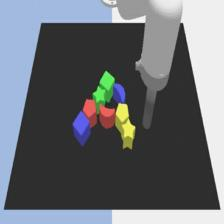
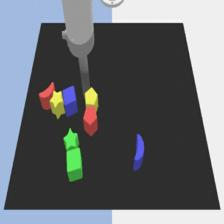
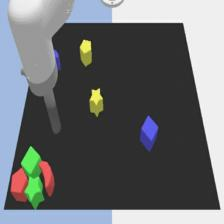
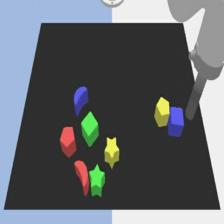
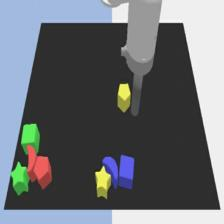
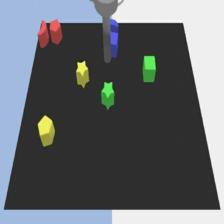
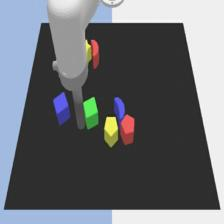
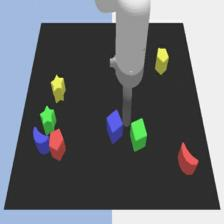

In [ ]:
# %%

if __name__ == "__main__":
    init_devices()
    model, tokenizer, params, decode = load_pretrained_model()
    trainable_mask = big_vision.utils.tree_map_with_names(is_trainable_param, params)

    # Define Shardings & apply it to params
    mesh = jax.sharding.Mesh(jax.devices(), ("data"))
    data_sharding = jax.sharding.NamedSharding(mesh, jax.sharding.PartitionSpec("data"))
    params_sharding = big_vision.sharding.infer_sharding(
        params, strategy=[(".*", 'fsdp(axis="data")')], mesh=mesh
    )

    warnings.filterwarnings("ignore", message="Some donated buffers were not usable")

    params = apply_params_sharding(
        params, params_sharding=params_sharding, trainable_mask=trainable_mask
    )

    # load datasets
    DATA_DIR_TRAIN = "./data/language_table_mini_train"
    train_dataset = big_vision.datasets.jsonl.DataSource(
        os.path.join(DATA_DIR_TRAIN, "_annotations.jsonl"),
        fopen_keys={"image": DATA_DIR_TRAIN},
    )

    DATA_DIR_VAL = "./data/language_table_mini_valid"
    val_dataset = big_vision.datasets.jsonl.DataSource(
        os.path.join(DATA_DIR_VAL, "_annotations.jsonl"),
        fopen_keys={"image": DATA_DIR_VAL},
    )

    show_train_samples()

Train Steps:  1000
Eval Steps:  250


2024-06-17 20:05:44.078353: W external/xla/xla/service/gpu/gemm_fusion_autotuner.cc:864] Slow kernel for gemm_fusion_dot.91 took: 1.407799316s. {block_m:16,block_n:16,block_k:256,split_k:1,num_stages:1,num_warps:4,num_ctas:1}
2024-06-17 20:06:03.396062: W external/xla/xla/service/hlo_rematerialization.cc:2948] Can't reduce memory use below 5.56GiB (5975136309 bytes) by rematerialization; only reduced to 7.67GiB (8235308084 bytes), down from 7.67GiB (8235380724 bytes) originally


step:  1/1000   lr: 0.00030   loss: 10.5749
step:  2/1000   lr: 0.00060   loss: 5.0784
step:  3/1000   lr: 0.00090   loss: 3.7551
step:  4/1000   lr: 0.00120   loss: 2.8623
step:  5/1000   lr: 0.00150   loss: 1.9233
step:  6/1000   lr: 0.00180   loss: 1.5228
step:  7/1000   lr: 0.00210   loss: 1.4336
step:  8/1000   lr: 0.00240   loss: 2.1309
step:  9/1000   lr: 0.00270   loss: 2.7956
step: 10/1000   lr: 0.00300   loss: 4.6230
step: 11/1000   lr: 0.00330   loss: 6.6777
step: 12/1000   lr: 0.00360   loss: 6.2043
step: 13/1000   lr: 0.00390   loss: 2.6661
step: 14/1000   lr: 0.00420   loss: 1.9481
step: 15/1000   lr: 0.00450   loss: 1.4679
step: 16/1000   lr: 0.00480   loss: 3.1764
step: 17/1000   lr: 0.00510   loss: 9.1701
step: 18/1000   lr: 0.00540   loss: 19.9121
step: 19/1000   lr: 0.00570   loss: 16.5153
step: 20/1000   lr: 0.00600   loss: 13.1663
step: 21/1000   lr: 0.00630   loss: 11.8399
step: 22/1000   lr: 0.00660   loss: 10.9310
step: 23/1000   lr: 0.00690   loss: 9.9526
step:


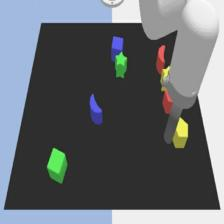
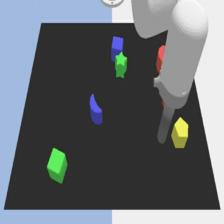
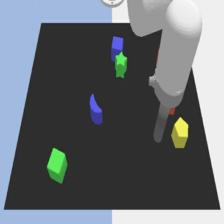
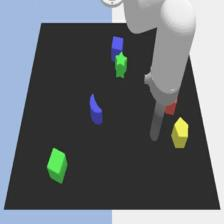

step: 251/1000   lr: 0.02797   loss: 2.3401
step: 252/1000   lr: 0.02794   loss: 2.3080
step: 253/1000   lr: 0.02792   loss: 2.2437
step: 254/1000   lr: 0.02789   loss: 2.2834
step: 255/1000   lr: 0.02786   loss: 2.2696
step: 256/1000   lr: 0.02784   loss: 2.2127
step: 257/1000   lr: 0.02781   loss: 2.2127
step: 258/1000   lr: 0.02778   loss: 2.2414
step: 259/1000   lr: 0.02775   loss: 2.2095
step: 260/1000   lr: 0.02773   loss: 2.2010
step: 261/1000   lr: 0.02770   loss: 2.1749
step: 262/1000   lr: 0.02767   loss: 2.1755
step: 263/1000   lr: 0.02764   loss: 2.1531
step: 264/1000   lr: 0.02761   loss: 2.1537
step: 265/1000   lr: 0.02759   loss: 2.1626
step: 266/1000   lr: 0.02756   loss: 2.1185
step: 267/1000   lr: 0.02753   loss: 2.0815
step: 268/1000   lr: 0.02750   loss: 2.0805
step: 269/1000   lr: 0.02747   loss: 2.1399
step: 270/1000   lr: 0.02744   loss: 2.0782
step: 271/1000   lr: 0.02741   loss: 2.0878
step: 272/1000   lr: 0.02738   loss: 2.0604
step: 273/1000   lr: 0.02735   l


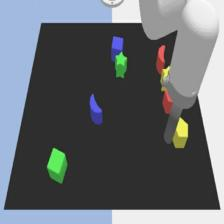
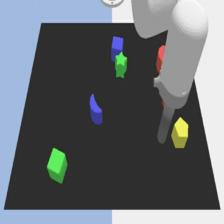
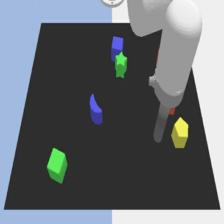
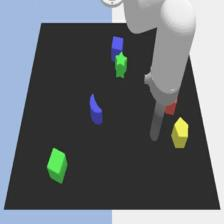

step: 501/1000   lr: 0.01758   loss: 1.4871
step: 502/1000   lr: 0.01752   loss: 1.4798
step: 503/1000   lr: 0.01747   loss: 1.4145
step: 504/1000   lr: 0.01742   loss: 1.4546
step: 505/1000   lr: 0.01737   loss: 1.3975
step: 506/1000   lr: 0.01732   loss: 1.4250
step: 507/1000   lr: 0.01727   loss: 1.4933
step: 508/1000   lr: 0.01721   loss: 1.4654
step: 509/1000   lr: 0.01716   loss: 1.5067
step: 510/1000   lr: 0.01711   loss: 1.5261
step: 511/1000   lr: 0.01706   loss: 1.5258
step: 512/1000   lr: 0.01701   loss: 1.4091
step: 513/1000   lr: 0.01696   loss: 1.4954
step: 514/1000   lr: 0.01690   loss: 1.4729
step: 515/1000   lr: 0.01685   loss: 1.4895
step: 516/1000   lr: 0.01680   loss: 1.4466
step: 517/1000   lr: 0.01675   loss: 1.5124
step: 518/1000   lr: 0.01670   loss: 1.4824
step: 519/1000   lr: 0.01664   loss: 1.4458
step: 520/1000   lr: 0.01659   loss: 1.3705
step: 521/1000   lr: 0.01654   loss: 1.4671
step: 522/1000   lr: 0.01649   loss: 1.4748
step: 523/1000   lr: 0.01644   l


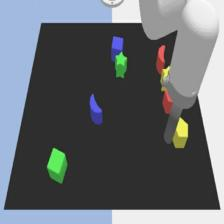
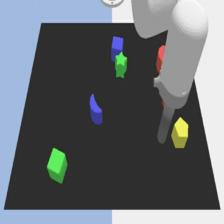
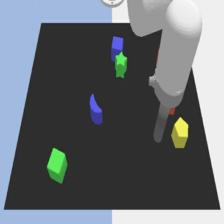
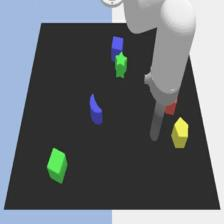

step: 751/1000   lr: 0.00535   loss: 1.5045
step: 752/1000   lr: 0.00531   loss: 1.4413
step: 753/1000   lr: 0.00527   loss: 1.4591
step: 754/1000   lr: 0.00523   loss: 1.4768
step: 755/1000   lr: 0.00519   loss: 1.4982
step: 756/1000   lr: 0.00515   loss: 1.3725
step: 757/1000   lr: 0.00511   loss: 1.4049
step: 758/1000   lr: 0.00507   loss: 1.3814
step: 759/1000   lr: 0.00503   loss: 1.3994
step: 760/1000   lr: 0.00499   loss: 1.4693
step: 761/1000   lr: 0.00495   loss: 1.4362
step: 762/1000   lr: 0.00491   loss: 1.4135
step: 763/1000   lr: 0.00488   loss: 1.4303
step: 764/1000   lr: 0.00484   loss: 1.5550
step: 765/1000   lr: 0.00480   loss: 1.4084
step: 766/1000   lr: 0.00476   loss: 1.4798
step: 767/1000   lr: 0.00472   loss: 1.4469
step: 768/1000   lr: 0.00468   loss: 1.4292
step: 769/1000   lr: 0.00465   loss: 1.4003
step: 770/1000   lr: 0.00461   loss: 1.4409
step: 771/1000   lr: 0.00457   loss: 1.4515
step: 772/1000   lr: 0.00453   loss: 1.4127
step: 773/1000   lr: 0.00450   l


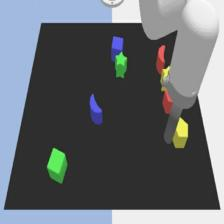
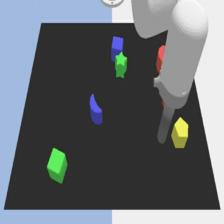
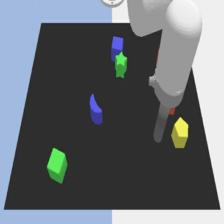
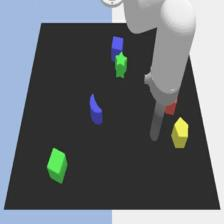

Model predictions


2024-06-17 23:21:19.420916: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



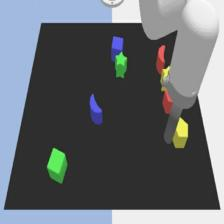
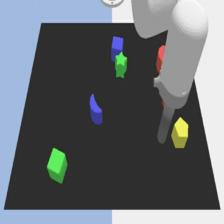
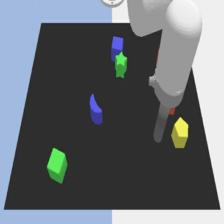
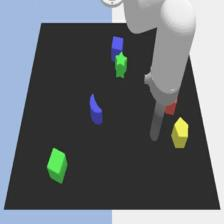
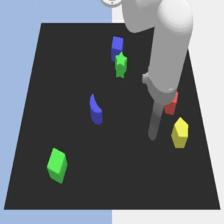
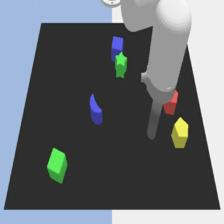
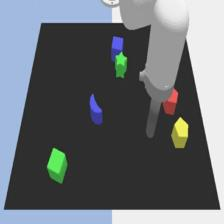
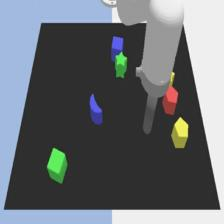
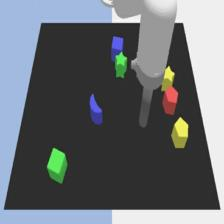
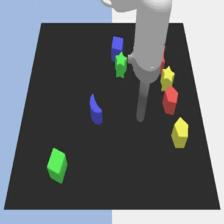
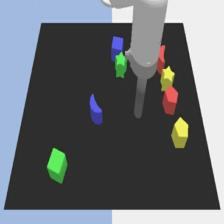
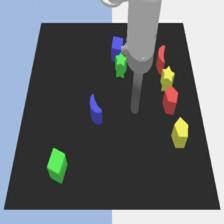
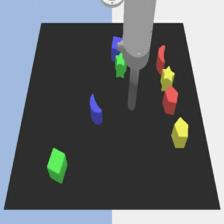
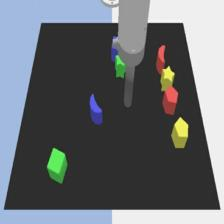
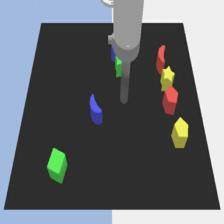
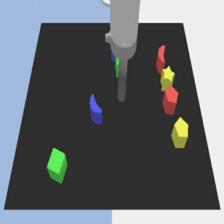
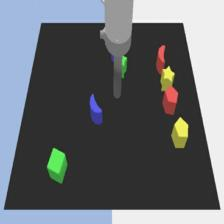
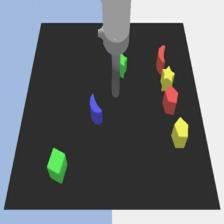
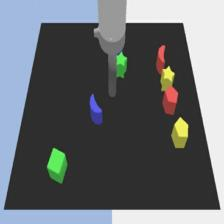
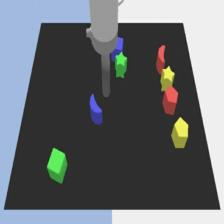
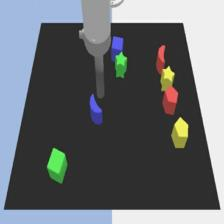
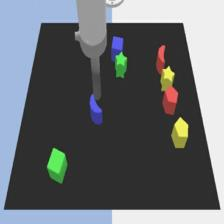
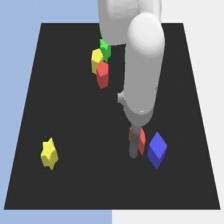
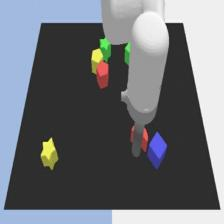
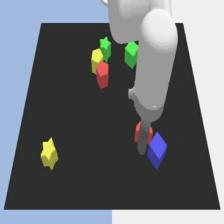
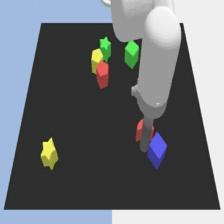
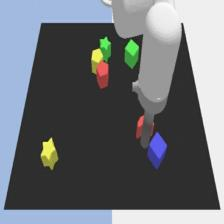
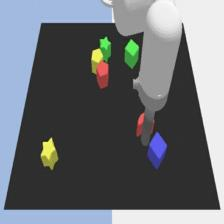
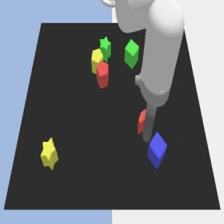
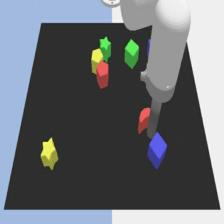
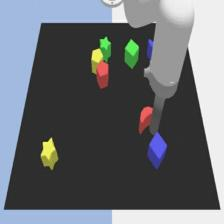
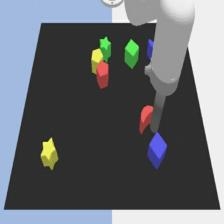
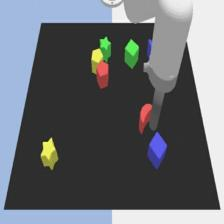
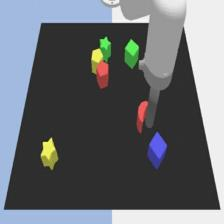
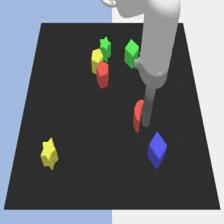
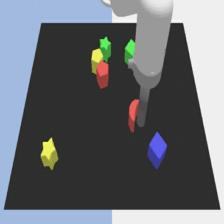
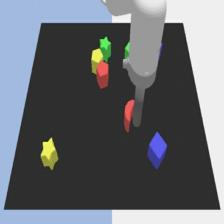
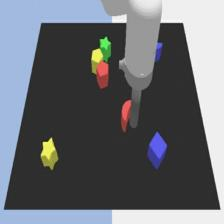
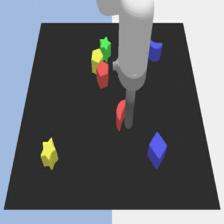
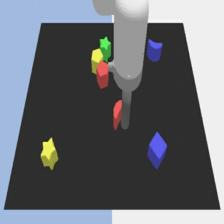
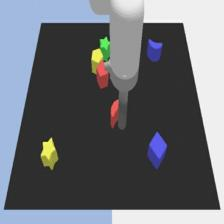
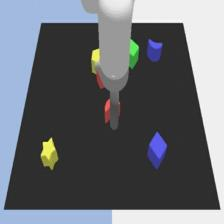
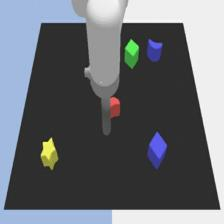
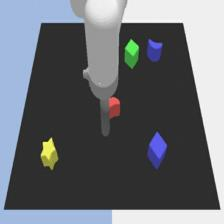
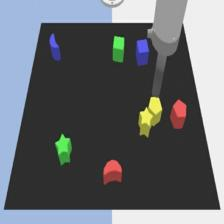
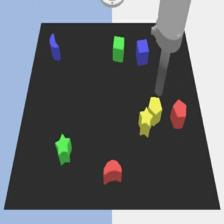
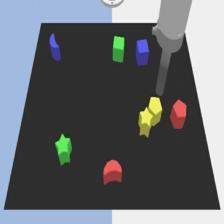
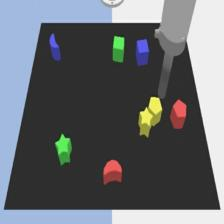
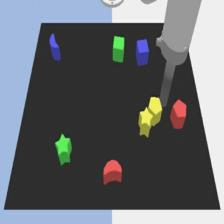
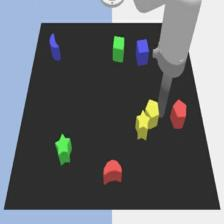
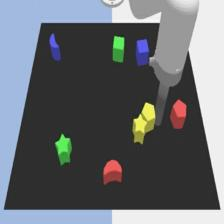
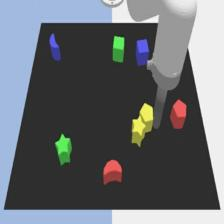
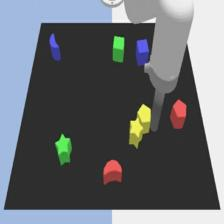
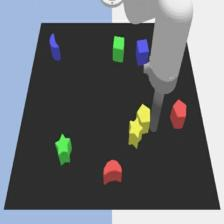
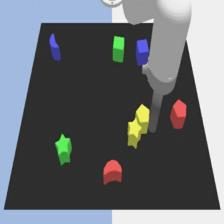
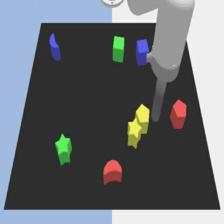
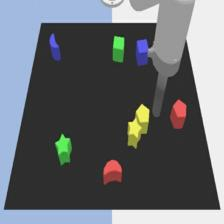
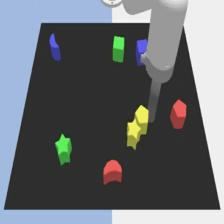
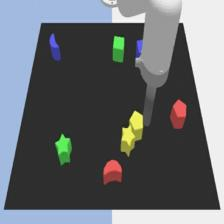
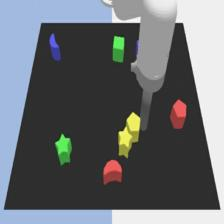
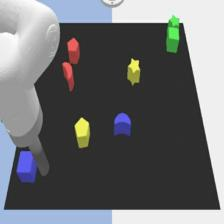
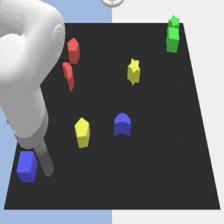
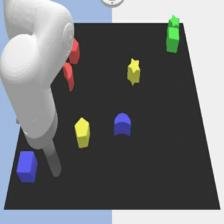
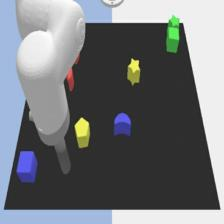
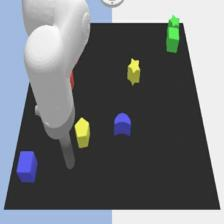
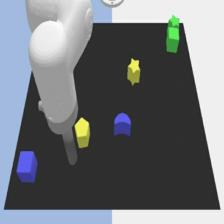
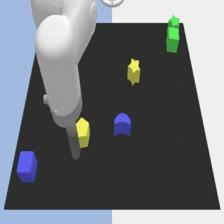
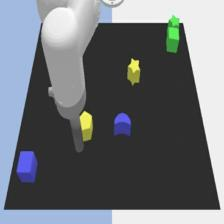
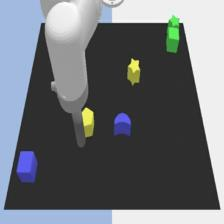
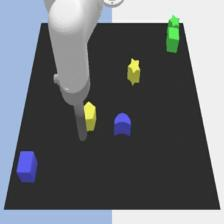
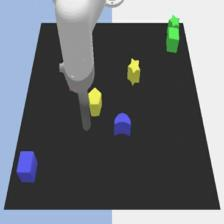
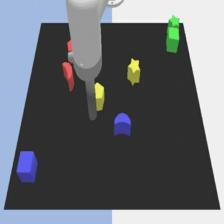
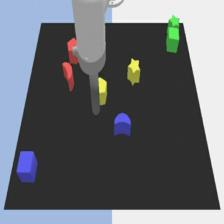
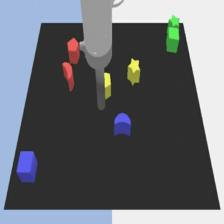
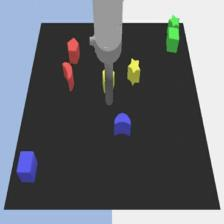
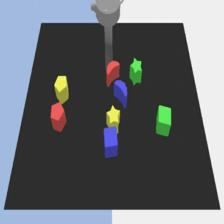
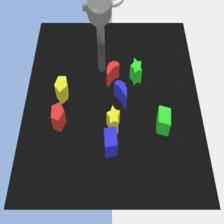
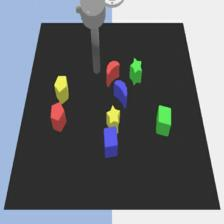
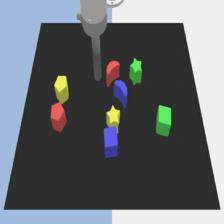
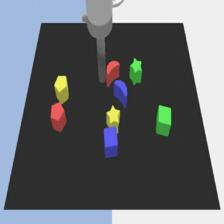
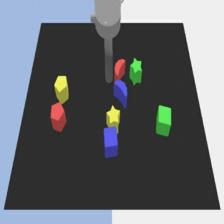
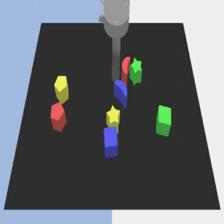
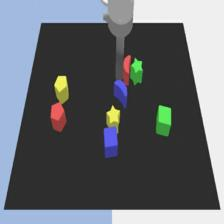
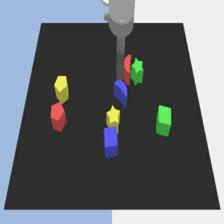
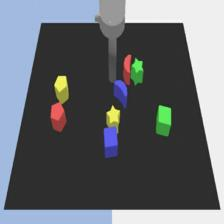
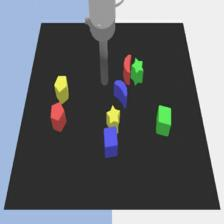
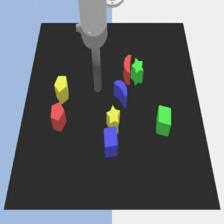
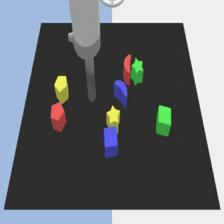
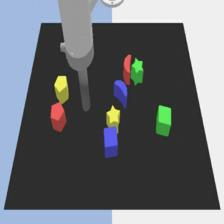

In [ ]:
    # %%

train(params=params)